### Summary:
1. How did you clean the data and what was wrong with it? Close to 90% of a Data Scientist's job is in cleaning data  
    - average_discount_used and coupon_discount_applied do not seem correct. Pls refer to Stage 2 section for more details.
2. What are the features you used as-is and which one did you engineer using the given ones? What do they mean in the real world?
   - Only change "Y" and "N" flag from is_newsletter_subscriber to 0,1 since model only deal with numeric values.
3. What does the output look like - how close is the accuracy of the prediction in light of data with labelled flags
    - Output is the probability for the infer_gender to be male or female. Current threshold used is 0.5 to convert output to {0,1} but it can be changed.
4. What other features and variables can you think of, that can make this process more robust? Can you make a recommendation of top 5 features you'd seek to find apart from the ones given here
    - customer pageview group by category
    - customer add to cart (not yet make payment) group by category
    - campaign (gender related) sales statistics
    - temporal data to detect trend, seasonal togehter with big events like World Cup
    - revenue by category and gender (can derive price range)
    

In [168]:
password = ''

In [32]:
import hashlib
from zipfile import ZipFile
import sqlite3
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.style.use('seaborn')
import datetime as dt
from sklearn.model_selection import train_test_split

# Stage 1

## Load data

In [ ]:
pwd = hashlib.sha256(password).hexdigest()
ZipFile('./input/test_data.db.zip').extractall(pwd=pwd)

In [25]:
sqlite_file = './test_data.db'
import sqlite3
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

In [28]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[(u'customers',)]


In [38]:
c.execute("SELECT * FROM customers limit 10;")
print [description[0] for description in c.description]

['customer_id', 'days_since_first_order', 'days_since_last_order', 'is_newsletter_subscriber', 'orders', 'items', 'cancels', 'returns', 'different_addresses', 'shipping_addresses', 'devices', 'vouchers', 'cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments', 'female_items', 'male_items', 'unisex_items', 'wapp_items', 'wftw_items', 'mapp_items', 'wacc_items', 'macc_items', 'mftw_items', 'wspt_items', 'mspt_items', 'curvy_items', 'sacc_items', 'msite_orders', 'desktop_orders', 'android_orders', 'ios_orders', 'other_device_orders', 'work_orders', 'home_orders', 'parcelpoint_orders', 'other_collection_orders', 'redpen_discount_used', 'coupon_discount_applied', 'average_discount_onoffer', 'average_discount_used', 'revenue']


In [48]:
c.execute("""
    SELECT
        count(*) 
    FROM customers;""")
c.fetchall()[:10]

[(46279,)]

> 1. What was the total revenue to the nearest dollar for customers who have paid by credit card?  
    > 50,372,282

In [64]:
c.execute("""
    SELECT
        ROUND(SUM(revenue)) AS total_revenue 
    FROM customers
    WHERE cc_payments = 1;""")
c.fetchall()[:5]

[(50372282.0,)]

In [67]:
c.execute("""
    SELECT
        customer_id,
        CASE(cc_payments)
            WHEN SUM(cc_payments) > 0 THEN "yes"
            ELSE "no" 
        END as paid_cc
    FROM customers
    GROUP BY customer_id
    HAVING paid_cc = 'no';""")
c.fetchall()[:5]

[]

> 2. What percentage of customers who have purchased female items have paid by credit card?  
    > 65%

In [63]:
c.execute("""
    SELECT
        cus_fe_item_paid_cc_cnt,
        cus_fe_item_cnt,
        cus_fe_item_paid_cc_cnt*1.0/cus_fe_item_cnt AS cus_fe_item_paid_cc_cnt_pc
    FROM (
        SELECT
            COUNT(DISTINCT customer_id) AS cus_fe_item_paid_cc_cnt
        FROM customers
        WHERE cc_payments = 1
            AND female_items > 0
    ) AS cus_fe_item_paid_cc
    LEFT JOIN (
        SELECT
            COUNT(DISTINCT customer_id) AS cus_fe_item_cnt
        FROM customers
        WHERE female_items > 0
    ) AS cus_fe_item
    ON 1
    ;""")
c.fetchall()

[(22483, 34335, 0.654812873161497)]

> 3. What was the average revenue for customers who used either iOS, Android or Desktop?  
    > 1493.04

In [70]:
c.execute("""
    SELECT
        SUM(revenue) AS rev_sum,
        COUNT(DISTINCT customer_id) AS cus_cnt,
        SUM(revenue)*1.0/COUNT(DISTINCT customer_id) AS rpc
    FROM customers
    WHERE desktop_orders +  android_orders + ios_orders > 0
""")
c.fetchall()

[(57141503.03000071, 38272, 1493.0367639527776)]

> We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

In [96]:
c.execute("""
    SELECT
        customer_id
    FROM (
        SELECT
            *
        FROM customers
    ) AS cus
    LEFT JOIN (
        SELECT
            SUM(revenue)*1.0/COUNT(DISTINCT customer_id) AS rpc_avg
        FROM customers
        WHERE revenue > 0
    ) AS rpc
    ON 1
    LEFT JOIN (
        SELECT
            SUM(male_items)*1.0/COUNT(DISTINCT customer_id) AS m_item_avg 
        FROM customers
        WHERE male_items > 0
    ) AS m_item
    ON 1
    WHERE revenue > rpc_avg
        AND male_items > m_item_avg
        AND is_newsletter_subscriber = 'Y'
""")
cus_men_lux_brand = c.fetchall()

In [99]:
print cus_men_lux_brand[:5]

[(u'040fb9742f9e14cf69c7a748bdf20137',), (u'e59717d9ec9c62b7966cef921323948a',), (u'2615678b8425cf1a9dd4989595be806a',), (u'048c683b41778df6a766c2289b2eb174',), (u'5dc61ca9e0c9f1237283042aabf87376',)]


# Stage 2

## Load data

In [170]:
pwd = hashlib.sha256(password).hexdigest()
js = ZipFile('./input/test_data.zip').read('data.json', pwd=pwd)
test = pd.read_json(js)
print( u"\u25B6 Loaded data.")

▶ Loaded data.


In [6]:
print u'\u2022 Test columns:\n',  test.dtypes
print ''
print 'Test shape: ', test.shape
with pd.option_context('display.max_columns', test.shape[1]):
    display(test.head(5))

• Test columns:
afterpay_payments             int64
android_orders                int64
apple_payments                int64
average_discount_onoffer    float64
average_discount_used       float64
cancels                       int64
cc_payments                   int64
coupon_discount_applied     float64
curvy_items                   int64
customer_id                  object
days_since_first_order        int64
days_since_last_order         int64
desktop_orders                int64
devices                       int64
different_addresses           int64
female_items                  int64
home_orders                   int64
ios_orders                    int64
is_newsletter_subscriber     object
items                         int64
macc_items                    int64
male_items                    int64
mapp_items                    int64
mftw_items                    int64
msite_orders                  int64
mspt_items                    int64
orders                        int64
other_collec

afterpay_payments  android_orders  apple_payments  \
0                  0               0               0   
1                  0               0               0   
2                  1               0               0   
3                  0               0               0   
4                  0               0               0   

   average_discount_onoffer  average_discount_used  cancels  cc_payments  \
0                    0.3364              3584.4818        0            1   
1                    0.1404              1404.0966        0            0   
2                    0.1851              1899.7270        2            1   
3                    0.0000              3875.6715        0            1   
4                    0.0000                 0.0000        0            1   

   coupon_discount_applied  curvy_items                       customer_id  \
0                   248.65            0  64f7d7dd7a59bba7168cc9c960a5c60e   
1                     0.00            0  fa7c64efd5c037ff2abcce571f9c1712   
2                   107.92            0  18923c9361f27583d2320951435e4888   
3                    90.90            0  aa21f31def4edbdcead818afcdfc4d32   
4                     0.00            0  668c6aac52ff54d4828ad379cdb38e7d   

   days_since_first_order  days_since_last_order  desktop_orders  devices  \
0                    2091                  15672              17        1   
1                    2082                    528               1        2   
2                    2072                    144              61        2   
3                    2054                  49200               2        1   
4                    2053                  49272               1        1   

   different_addresses  female_items  home_orders  ios_orders  \
0                    0            46            1           0   
1                    0            24            9           0   
2                    1           147           11           0   
3                    0             0            0           0   
4                    0             1            0           0   

  is_newsletter_subscriber  items  macc_items  male_items  mapp_items  \
0                        N     50           1           2           2   
1                        Y     26           4           0           0   
2                        Y    152          17           3           2   
3                        Y      2           0           0           1   
4                        Y      1           0           0           0   

   mftw_items  msite_orders  mspt_items  orders  other_collection_orders  \
0           0             0           0      17                       16   
1           0            12           0      13                        4   
2           0            10           0      71                       60   
3           0             0           0       2                        2   
4           0             0           0       1                        1   

   other_device_orders  parcelpoint_orders  paypal_payments  \
0                    0                   0                0   
1                    0                   0                1   
2                    0                   0                0   
3                    0                   0                0   
4                    0                   0                0   

   redpen_discount_used  returns   revenue  sacc_items  shipping_addresses  \
0               4554.39        1   6946.34           0                   4   
1                629.03        5   5329.28           0                   4   
2               6269.71        2  14133.87           0                   6   
3                  0.00        0    143.64           0                   1   
4                  0.00        0      0.00           0                   1   

   unisex_items  vouchers  wacc_items  wapp_items  wftw_items  work_orders  \
0             2         3           1          35           7         

In [7]:
print u'\u2022 Each row is unique.' \
    if test.customer_id.nunique() == test.shape[0] \
    else u'\u2022 Oops! {} ({:.2f}%) duplicated rows in test set'.format(
        test.shape[0] - test.customer_id.nunique(),
        (1 - test.customer_id.nunique()*1.0/test.shape[0])*100)
print u'\u2022 No missing values.'\
    if test.count().min() == test.shape[0] \
    else u'\u2022 Oops! {} ({:.2f}%) missing values found in test set.'\
        .format(test.shape[0] - test.count().min(), (test.shape[0] - test.count().min())*100.0/test.shape[0])

• Oops! 249 (0.54%) duplicated rows in test set
• Oops! 10205 (22.05%) missing values found in test set.


>*It needs to be cautious to drop duplicates and without cross validation. We need to make sure it's true duplicated observation with exactly the same feature values before dropping.*

In [8]:
test = test.drop_duplicates()
print u'\u25B6 Dropped duplicates in test set.'
print 'Test shape: ', test.shape

▶ Dropped duplicates in test set.
Test shape:  (46030, 43)


> *There are missing values in coupon_discount_applied.*  
    > - *vouchers are either 0(~99.99%) or 1(~0.01%) in those cases*

In [9]:
test[test.coupon_discount_applied.isnull()]\
    [['items', 'revenue', 'average_discount_used', 'vouchers', 'coupon_discount_applied'
     , 'average_discount_onoffer', 'redpen_discount_used']].head()

items  revenue  average_discount_used  vouchers  \
5775      2   272.64                 0.0000         0   
7079      5   338.50              6796.9843         0   
7233      2   105.30              1500.9639         0   
8502      1    59.08                 0.0000         0   
8699      2   116.30              5999.5632         0   

      coupon_discount_applied  average_discount_onoffer  redpen_discount_used  
5775                      NaN                    0.0000                  0.00  
7079                      NaN                    0.6797                728.45  
7233                      NaN                    0.1501                 21.80  
8502                      NaN                    0.0000                  0.00  
8699                      NaN                    0.6000                174.42

In [10]:
display(pd.crosstab('count'
                    , test[test.coupon_discount_applied.isnull()].vouchers
                    , rownames=[None])/len(test[test.coupon_discount_applied.isnull()]))

vouchers         0         1
count     0.999902  0.000098

In [11]:
test[(test.coupon_discount_applied.isnull()) & (test.vouchers == 1)]\
     [['items', 'revenue', 'vouchers'
      , 'average_discount_used', 'average_discount_onoffer'
      , 'coupon_discount_applied', 'redpen_discount_used']]

items  revenue  vouchers  average_discount_used  \
33933      1    23.86         1              2499.2141   

       average_discount_onoffer  coupon_discount_applied  redpen_discount_used  
33933                    0.2499                      NaN                  7.95

In [12]:
print(u'\u25B6 Based on values on the other columns, it should be imputed as 0.')
test.loc[(test.coupon_discount_applied.isnull()), 'coupon_discount_applied'] = 0

▶ Based on values on the other columns, it should be imputed as 0.


In [13]:
print u'\u2022 Test unique values count:\n',\
    test[['customer_id', 'afterpay_payments', 'apple_payments', 'paypal_payments', 'cc_payments'
          , 'devices', 'different_addresses', 'shipping_addresses', 'is_newsletter_subscriber']]\
    .nunique(dropna=False)

• Test unique values count:
customer_id                 46030
afterpay_payments               2
apple_payments                  2
paypal_payments                 2
cc_payments                     2
devices                         3
different_addresses             2
shipping_addresses             15
is_newsletter_subscriber        2
dtype: int64


### Values set validation
    * Value set check
    * Logical relationship among columns

In [37]:
print(u'\u2022 Payments related fields has {} values {}.'.format(test.afterpay_payments.nunique()
    , str(set(test.afterpay_payments) | set(test.paypal_payments) | set(test.apple_payments)\
         | set(test.paypal_payments) | set(test.cc_payments))))
print(u'\u2022 devices field has {} values {}.'.format(test.devices.nunique()
    , str(set(test.devices))))
print(u'\u2022 is_newsletter_subscriber field has {} values {}.'.format(test.is_newsletter_subscriber.nunique()
    , str(set(test.is_newsletter_subscriber))))

• Payments related fields has 2 values set([0, 1]).
• devices field has 3 values set([1, 2, 3]).
• is_newsletter_subscriber field has 2 values set([u'Y', u'N']).


In [39]:
test['is_newsletter_subscriber'] = 1 * (test.is_newsletter_subscriber.values == 'Y')

In [15]:
print(u'\u2022 items and revenue fields are ok.') \
    if len(test[(test.items == 0) & (test.revenue > 0)]) == 0 \
        and len(test[(test.items > 0) & (test.revenue == 0)]) == 0 \
    else u'''\u2022 Oops! There are {}({:.2f}%) rows that have (items = 0 & revenue > 0),
                  {}({:.2f}%) rows that have (items > 0 & revenue = 0)'''.format(
        len(test[(test.items == 0) & (test.revenue > 0)])
        , len(test[(test.items == 0) & (test.revenue > 0)])*100.0/len(test)
        , len(test[(test.items > 0) & (test.revenue == 0)])
        , len(test[(test.items > 0) & (test.revenue == 0)])*100.0/len(test))

• Oops! There are 0(0.00%) rows that have (items = 0 & revenue > 0),
                  1520(3.30%) rows that have (items > 0 & revenue = 0)


>*It might be free item or due to the discount but let's look at raw data.*
    >- *There are rows with items > 0 but all discounts related columns and revenue are 0.*
    >- *There are rows with items > 0, discount related columns > 0 but revenue = 0.*
    >- *average_discount_used does not look correct.*

In [16]:
test[(test['items'] > 0) & (test.revenue == 0)]\
    [['items', 'cancels', 'returns', 'revenue', 'vouchers'
      , 'average_discount_used', 'average_discount_onoffer'
      , 'coupon_discount_applied', 'redpen_discount_used']].head(10)

items  cancels  returns  revenue  vouchers  average_discount_used  \
4       1        0        0      0.0         0                 0.0000   
9       1        1        0      0.0         0                 0.0000   
18      1        1        0      0.0         0                 0.0000   
32      2        1        0      0.0         1              9423.5969   
60      1        1        0      0.0         0                 0.0000   
62      3        0        0      0.0         0                 0.0000   
70      1        0        0      0.0         1             10000.0000   
79      7        0        0      0.0         0              2028.1646   
91      4        0        0      0.0         1              4998.8999   
94      3        0        0      0.0         0                 0.0000   

    average_discount_onoffer  coupon_discount_applied  redpen_discount_used  
4                     0.0000                     0.00                  0.00  
9                     0.0000                     0.00                  0.00  
18                    0.0000                     0.00                  0.00  
32                    0.0000                   160.00                  0.00  
60                    0.0000                     0.00                  0.00  
62                    0.0000                     0.00                  0.00  
70                    0.0000                    59.95                  0.00  
79                    0.2028                     0.00               1165.43  
91                    0.0000                    90.88                  0.00  
94                    0.0000                     0.00                  0.00

>*Check vouchers and coupon_discount_applied columns.*
    >- *there are rows with vouchers = 0 but coupon_discount_applied > 0.*
    >- *there are rows with vouchers > 0 but coupon_discount_applied == 0.*

In [17]:
print(u'\u2022 vouchers and coupon_discount_applied fields are ok.') \
    if len(test[(test.vouchers == 0) & (test.coupon_discount_applied > 0)]) == 0 \
        and len(test[(test.vouchers > 0) & (test.coupon_discount_applied == 0)]) == 0 \
    else u'''\u2022 Oops! There are {}({:.2f}%) rows that have (vouchers = 0 & coupon_discount_applied > 0),
                  {}({:.2f}%) rows that have (vouchers > 0 & coupon_discount_applied = 0)'''.format(
        len(test[(test.vouchers == 0) & (test.coupon_discount_applied > 0)])
        , len(test[(test.vouchers == 0) & (test.coupon_discount_applied > 0)])*100.0/len(test)
        , len(test[(test.vouchers > 0) & (test.coupon_discount_applied == 0)])
        , len(test[(test.vouchers > 0) & (test.coupon_discount_applied == 0)])*100.0/len(test))

• Oops! There are 4(0.01%) rows that have (vouchers = 0 & coupon_discount_applied > 0),
                  360(0.78%) rows that have (vouchers > 0 & coupon_discount_applied = 0)


In [18]:
test[(test.vouchers == 0) & (test.coupon_discount_applied > 0)]\
    [['items', 'revenue', 'vouchers'
      , 'average_discount_used', 'average_discount_onoffer'
      , 'coupon_discount_applied', 'redpen_discount_used']].head(10)

items  revenue  vouchers  average_discount_used  \
7867       1     0.00         0              2000.0000   
8109       2     0.00         0              1999.6454   
9185       1     0.00         0              2000.0000   
21807      4   185.26         0              3000.0786   

       average_discount_onoffer  coupon_discount_applied  redpen_discount_used  
7867                       0.00                    44.00                   0.0  
8109                       0.00                    69.04                   0.0  
9185                       0.00                    10.90                   0.0  
21807                      0.25                    19.08                  68.1

In [19]:
print(u'\u25B6 Based on values on the other columns, voucher could be imputed as 1.')
test.loc[(test.vouchers == 0) & (test.coupon_discount_applied > 0), 'vouchers'] = 1

▶ Based on values on the other columns, voucher could be imputed as 1.


In [20]:
test[(test.vouchers > 0) & (test.coupon_discount_applied == 0)]\
    [['items', 'revenue', 'vouchers'
      , 'average_discount_used', 'average_discount_onoffer'
      , 'coupon_discount_applied', 'redpen_discount_used']].head(10)

items  revenue  vouchers  average_discount_used  \
165      13  2432.72         1              3464.6656   
502      19   887.78         1              3858.9250   
620       8  1018.99         1              3066.8434   
954      21  1911.45         1               840.0157   
1042     20  1148.87         1              5224.1745   
1599      5   491.09         1               600.0373   
1676      9   919.74         1               517.5818   
1728     12  2009.96         1               687.2592   
2101     22  2886.98         1              2492.5483   
2255     11   920.13         2              1119.7797   

      average_discount_onoffer  coupon_discount_applied  redpen_discount_used  
165                     0.3465                      0.0                892.89  
502                     0.3859                      0.0                517.43  
620                     0.3067                      0.0                479.69  
954                     0.0840                      0.0                213.10  
1042                    0.5224                      0.0               1467.30  
1599                    0.0600                      0.0                 16.09  
1676                    0.0518                      0.0                 70.88  
1728                    0.0687                      0.0                169.83  
2101                    0.2493                      0.0               1149.50  
2255                    0.1120                      0.0                105.32

In [21]:
print(u'\u25B6 Based on values on the other columns, voucher could be imputed as 0.')
test.loc[(test.vouchers > 0) & (test.coupon_discount_applied == 0), 'vouchers'] = 1

▶ Based on values on the other columns, voucher could be imputed as 0.


In [22]:
print(u'\u2022 average_discount_onoffer and redpen_discount_used fields are ok.') \
    if len(test[(test.average_discount_onoffer == 0) & (test.redpen_discount_used > 0)]) == 0 \
        and len(test[(test.average_discount_onoffer > 0) & (test.redpen_discount_used == 0)]) == 0 \
    else u'''\u2022 Oops! There are {}({:.2f}%) rows that have (vouchers = 0 & redpen_discount_used > 0),
                  {}({:.2f}%) rows that have (vouchers > 0 & redpen_discount_used = 0)'''.format(
        len(test[(test.average_discount_onoffer == 0) & (test.redpen_discount_used > 0)])
        , len(test[(test.average_discount_onoffer == 0) & (test.redpen_discount_used > 0)])*100.0/len(test)
        , len(test[(test.average_discount_onoffer > 0) & (test.redpen_discount_used == 0)])
        , len(test[(test.average_discount_onoffer > 0) & (test.redpen_discount_used == 0)])*100.0/len(test))

• average_discount_onoffer and redpen_discount_used fields are ok.


> *Attempt to derive average_discount_used*  
    > - *average_discount_used = (coupon_discount_applied+redpen_discount_used) / items*

In [23]:
test.loc[:, 'average_discount_used'] \
    = (test['redpen_discount_used'] + test['coupon_discount_applied']) / test['items']
print(u'\u25B6 Fix average_discount_used')

▶ Fix average_discount_used


# Stage 3

### Model

> - Train is created for the purpose of testing only.  
> - infer_gender columns is created based on male vs female items (testing purpose only) so the 2 cols are excluded but for the actual train set, they should be included.

In [70]:
train = test.copy()
train['infer_gender'] = 1 * (train.male_items > train.female_items)

feature_names = list(train.columns)
do_not_use_for_training = ['customer_id', 'infer_gender', 'male_items', 'female_items']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print u'\u25B6 Feature names: ', feature_names
print(u'\u2022 We have %i features.' % len(feature_names))
print u'\u2022 Features count:\n', train[feature_names].count()

y = train['infer_gender'].values
print(u'\n\u25B6 Created y from target columns.')

# t1 = dt.datetime.now()
# print('\nFeature extraction time: %i seconds' % (t1 - t0).seconds)

▶ Feature names:  [u'afterpay_payments', u'android_orders', u'apple_payments', u'average_discount_onoffer', u'average_discount_used', u'cancels', u'cc_payments', u'coupon_discount_applied', u'curvy_items', u'days_since_first_order', u'days_since_last_order', u'desktop_orders', u'devices', u'different_addresses', u'home_orders', u'ios_orders', u'is_newsletter_subscriber', u'items', u'macc_items', u'mapp_items', u'mftw_items', u'msite_orders', u'mspt_items', u'orders', u'other_collection_orders', u'other_device_orders', u'parcelpoint_orders', u'paypal_payments', u'redpen_discount_used', u'returns', u'revenue', u'sacc_items', u'shipping_addresses', u'unisex_items', u'vouchers', u'wacc_items', u'wapp_items', u'wftw_items', u'work_orders', u'wspt_items']
• We have 40 features.
• Features count:
afterpay_payments           46030
android_orders              46030
apple_payments              46030
average_discount_onoffer    46030
average_discount_used       46030
cancels                     4

In [151]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense

def getModel(input_dim, layers, hidden_units):
    model = Sequential()
    
    model.add(Dense(hidden_units[0], input_dim=input_dim, activation='relu'))
    for i in range(1, layers-1):
        model.add(Dense(hidden_units[i], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    
    return model

In [152]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

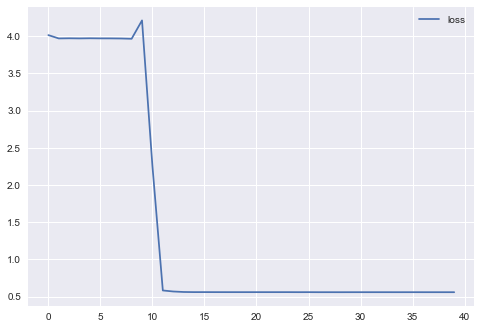

In [153]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1991)
model = getModel(len(feature_names), 4, [10,40,30])
model.fit(Xtr, ytr, validation_data=(Xv,yv), 
                    epochs=40,callbacks=[plot_losses])

In [154]:
scores = model.evaluate(np.array(Xv),np.array(yv))
print("Loss:", scores[0])
print("Accuracy", scores[1]*100)

9206/9206 [==============================] - 0s 20us/step
('Loss:', 0.55857345042295)
('Accuracy', 75.34216815379555)


In [166]:
pred = model.predict(Xv)
pred = np.round(pred).astype(int).reshape(1,-1)[0]
from sklearn.metrics import confusion_matrix
m = confusion_matrix(pred,yv)
tn, fn, fp, tp=confusion_matrix(yv, pred).ravel()
m = pd.crosstab(yv, pred, rownames=['actual'], colnames=['pred'])

### Predict

In [82]:
ytest = model.predict(test[feature_names])
ytest = np.round(ytest).astype(int).reshape(1,-1)[0]